In [2]:
source("./Functions/MOCL.R") 
source("./Functions/lambda_selection.R")
source("./Functions/MOCL_wcss.R")
source("./Functions/Adaptive_MAM.R") 

source("./Functions/SKM_gap.R")
source("./Functions/evaluation.R")

library(VarSelLCM) # VarselLCM
library(cluster)     # PAM

library(ggplot2)
library(gridExtra)
library(ggpubr)

library(ggthemes)
library(GGally)
library(RColorBrewer)
library(corrplot)
library(dplyr)
library(pdfCluster)
library(fossil)
options(warn=-1)
library(Rtsne)
library(latex2exp)

# CHR

In [3]:
clu_kk=c(1:4)
mu_or=0.792*(1)
x1=mu_or*2*clu_kk
x2=-mu_or*(1/10)*exp(clu_kk)
x3=mu_or*7*log(clu_kk)

mu_mat_or=cbind(x1,x2,x3)
mu_v_or=apply(mu_mat_or,2,mean)

for(i in 1:4){
    if(i==1){
        m_or=mu_mat_or[i,]%*%t(mu_mat_or[i,])
    }else{
        m_or=m_or+mu_mat_or[i,]%*%t(mu_mat_or[i,])
    }
}
bc_or=sum(diag(m_or/4-mu_v_or%*%t(mu_v_or)))
wc_or=sum(diag(4^(-1)*4*diag(3)))

CHI_or=bc_or/wc_or


###################################
mu_no=5
mu_mat_no=mu_no*diag(4)
mu_v_no=apply(mu_mat_no,2,mean)

for(i in 1:4){
    if(i==1){
        m_no=mu_mat_no[i,]%*%t(mu_mat_no[i,])
    }else{
        m_no=m_no+mu_mat_no[i,]%*%t(mu_mat_no[i,])
    }
}
bc_no=sum(diag(m_no/4-mu_v_no%*%t(mu_v_no)))
wc_no=sum(diag(4^(-1)*4*diag(4)))

CHI_no=bc_no/wc_no


sqrt(CHI_no/CHI_or)

[1] 1.000329

In [4]:
setting_K4<-function(mu_or=1,n_k_lst=c(50,50,50,50),
                                p=20,seed=1234,mu_no=10){
    set.seed(seed)
    K=length(n_k_lst)
    n=sum(n_k_lst)
    
    for(i in 1:K){
        if(i==1){
            clu_k=c(rep(i,n_k_lst[i]))
        }else{
            clu_k=c(clu_k,rep(i,n_k_lst[i]))
        }
    }
    
    mu_1=mu_or*(2*clu_k)
    mu_2=-mu_or*(exp(clu_k)/10)
    mu_3=mu_or*(7*log(clu_k))
    
    
    # Data generation
    x1=mu_1+rnorm(n,0,1)
    x2=mu_2+rnorm(n,0,1)
    x3=mu_3+rnorm(n,0,1)
    
    data_x=scale(cbind(x1,x2,x3))
    
    ############################
    # Data corresponding to nominal clusters
    mu_no_mat=diag(K)
    
    # Nominal cluster generation
    x_no=matrix(0,n,ncol(mu_no_mat))
    p_lst=runif(n,0,1)
    clu_no=p_lst*0
    for(i in 1:K){
        clu_no=clu_no+(p_lst>=((i-1)/K))
    }
    #clu_no
    for(i in 1:nrow(x_no)){
        x_no[i,]=mu_no*mu_no_mat[clu_no[i],]
    }

    for(i in 1:ncol(x_no)){
        x_no[,i]=x_no[,i]+rnorm(nrow(x_no),0,1)
    }

    colnames(x_no)=paste("x_no",1:(ncol(x_no)),sep="_")
    
    ###############################
    # Noise variables
    p_e=p-ncol(data_x)-ncol(x_no)
    noise_mat=nor_minmax(matrix(rnorm(n*p_e,0,1),n,p_e))
    colnames(noise_mat)=paste("noise",1:(ncol(noise_mat)),sep="_")
    
    data=scale(cbind(data_x,x_no,noise_mat))
    
    ## clustering
    kk=K
    pam <- pam(data,kk)
    km <- KMeans_rcpp(data,kk)
    mocl <- MOCL_wcss(Xf=data,k=kk,lambda_seq=seq.default(from=0.001,to=3,length=50),delta=0.01)
    skm <- Sparse_km(data=data,kk=kk,nperms_n=10)
    varsel <- VarSelCluster(data, kk, nbcores = 2, crit.varsel = 'BIC') 
    
    
    # clusters
    cluster_mat=rbind(mocl$cluster,
                     skm$cluster_best,
                     skm$cluster_1sd,
                     fitted(varsel),
                     km$cluster,
                     pam$cluster)
    
    rownames(cluster_mat)=c("MOCL_wcss","SKM_best","SKM_1sd","VSL","KMPP","PAM")
    
    sparse_mat=rbind(t(matrix(apply(abs(mocl$fx),2,sum)>0)),
                    skm$sparse_best,skm$sparse_1sd,
                     slot(slot(varsel,'model'),'omega'))
    
    rownames(sparse_mat)=c("MOCL","SKM_best","SKM_1sd","VSL")
    
    rand_mat=t(matrix(c(rand.index(clu_k,mocl$cluster),
                         rand.index(clu_k,skm$cluster_best),
                         rand.index(clu_k,skm$cluster_1sd),
                         rand.index(clu_k,fitted(varsel)),
                         rand.index(clu_k,km$cluster),
                         rand.index(clu_k,pam$cluster))))
    
    colnames(rand_mat)=c("MOCL","SKM_best","SKM_1sd","VSL","KMPP","PAM")
    kendall=cor(clu_k,mocl$cluster,method="kendall")
    
    
    if(p==ncol(data_x)){
        TP_FP_mat=cbind(apply(sparse_mat[,c(1:ncol(data_x))],1,mean),
                        c(rep(0,nrow(sparse_mat))))
    }
    if(p>ncol(data_x)){
        TP_FP_mat=cbind(apply(sparse_mat[,c(1:ncol(data_x))],1,mean),
                    apply(sparse_mat[,c((ncol(data_x)+1):ncol(sparse_mat))],1,mean))
    }
    
    rand_no=rand.index(clu_k,clu_no)
    return(list(cluster=clu_k,clu_no=clu_no,rand_no=rand_no,cluster_mat=cluster_mat,data=data,mocl_lam=mocl$lambda_sel_mat,
                sparse_mat=sparse_mat,rand_mat=rand_mat,TP_FP_mat=TP_FP_mat,kendall=kendall,
                fx_mocl=mocl$fx,
                coef_mocl=mocl$coef,
                weight_skm=skm$weigth_best,weight_skm_1sd=skm$weigth_1sd))
}

## Clustering

In [7]:
iter_n=100

In [8]:
ss=43
set.seed(ss)
seed_r=round(runif(25000,1,30000))
models_0=list()
models_1=list()
models_2=list()
models_3=list()
models_4=list()
models_5=list()

Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+22]
    models_0[[i]]=setting_K4(mu_or=0.792*(1/0.1),mu_no=5,seed=seed_rr)  
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+22]
    models_1[[i]]=setting_K4(mu_or=0.792*(1/0.3),mu_no=5,seed=seed_rr)  
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+21]
    models_2[[i]]=setting_K4(mu_or=0.792*(1/0.5),mu_no=5,seed=seed_rr)  
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+224]
    models_3[[i]]=setting_K4(mu_or=0.792*(1/0.7),mu_no=5,seed=seed_rr)  
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+25]
    models_4[[i]]=setting_K4(mu_or=0.792*(1/0.9),mu_no=5,seed=seed_rr)   
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+223]
    models_5[[i]]=setting_K4(mu_or=0.792*(1/1.1),mu_no=5,seed=seed_rr)  
}
Sys.time()



[1] "2024-08-03 20:07:29 KST"

012
0123
012
012
01234
01234
012
012
012
012
012
012
012
0123
012
012
01234
01234
0123
012
0123
0123
012
012345
012
01234
0123
012
012
01234
012
0123
012
012
012
012
012
012
012
012
012
012
012
012
012
012
0123
01234
012
01234
012
01234
012
012
012
012
012
0123
012
012
012
0123
012
012
012
012
01234
0123
012
0123
012
0123
012
012
012
012
0123
012
01234
01234
0123
012
0123
012
012
012
012
012
012
012
0123
0123
0123
012
012
012
012
012
012
01234
012
012
012
0123
0123
0123
012
012
0123
0123
012
012
012
012
0123
0123
012
012345
012
012
012
012
012345
012
012
0123
012
012345
012
012
01234
0123
012
012
01234
012345
012
01
01234
0123
012
012
012
012
0123
0123
012
012
012
012
012
012
012
012345
0123
0123
0123
0123
012
0123
012
012
012
01
0123
0123
012
012
012
0123
012
012
012
012
012
012
012
012
01234
01234
0123
01234
012
012345
0123
01234
012
0123
01234
01234
012
012345
01234
012
0123
012
0123
0123
012
0123


[1] "2024-08-03 20:31:23 KST"

0123
012
012
012
012
01234
012
012
012
01234
012
012
0123
0123
012
0123
01234
0123
0123
012345
012
01234
01234
01234
0123
012
0123
0123
0123
01234
012
0123
012
012
012
012
0123
0123
012
012
012
012
01234
012
012
012
0123
01234
012
012
012
012
012
012
012
012
01234
012345
012
012
012
012
012
012
012
012
012
012
012
01234
012
0123
012
01234
012
01234
012
012
012
012345
0123
012
0123
0123
01234
012345
012
012
0123
0123
012
012
012
0123
012
012
012
012
012
01234
01234
012
012
012
0123
01234
012
012
012345
0123
012
0123
012
012
012
0123
01234
0123
012
012
012
012
0123
012
012
012
012
012345
012
012
0123
01234
012
01234
0123
0123
0123
012
012345
012
01234
012
0123
012
012
012
012
012
0123
012
012
012
012
012
012
012
012
012
012
012
012
012
012
012
01234
01234
012
012
012
012
0123
012
0123
0123
012
012
012
012
01234
01234
012
01234
0123
012
01234
0123
012
0123
012345
012345
012
0123
012
0123
012
012
012
0123
012
012


[1] "2024-08-03 20:53:38 KST"

012
0123
012
012
012
0123
012345
0123
012
012
0123
01234
012
012
0123
0123
012345
012345
0123
012
01234
01234
0123
012
012
012
012345
012
0123
012
0123
012345
0123
012
0123
0123
012
012
012
0123
0123
0123
0123
01234
012
0123
0123
0123
0123
0123
01234
0123
0123
01234
012
012
01234
01234
012
012
0123
01234
0123
012345
0123
01234
0123
012345
012
012
01234
012
0123
01234
012
01234
012
012
0123
0123
0123
0123
012
012
01234
0123
012
012
012
0123
012
0123
012
012
012
0123
012
012
012
012345
012
012
012
012
012
01234
01234
0123
0123
012345
012
01234
012345
012345
01234
012345
0123
0123
012
0123
01234
012345
0123
012345
012
012
0123
012
0123
012345
01234
01234
0123
0123
01234
01234
012
01234
012
012345
012
0123
0123
012
012
012
012
012
012
0123
0123
012
012
012
012
012
012
0123
012
0123
01234
012
01234
01234
012
012
012
01234
012
0123
012
012
0123
012
01234
01234
012345
01234
012345
012345
0123
01234
012
012345
01234
012345
0123
012
01234
0123
012
012
012
012
0123
012
012
012345
0123
0123


[1] "2024-08-03 21:17:19 KST"

0123
012
012
0123
012
01234
01234
01234
012
012345
0123
012
0123
012
012345
012345
0123
012
012
012
012
0123
012345
012345
012
0123
01234
0123
012
01234
0123
012
012
0123
012
01234
0123
012345
012
0123
01234
01234
0123
0123
0123
01234
0123
01234
01234
012345
0123
012
012
012345
012
012
01234
01234
012
012
0123
012
012
012
0123
01234
01234
0123
012345
012
012
012345
012
012
01234
01234
0123
0123
0123
0123
0123
01234
012
012
012345
01234
012345
01234
0123
0123
012
012
012
012
012345
01234
0123
012
01234
0123
012
012345
0123
0123
012
0123
0123
012345
0123
0123
0123
012345
012345
01234
0123
012
01234
01234
0123
012
01234
01234
012
0123
012
0123
0123
0123
012
0123
012
012345
012
012345
012345
012345
0123
0123
0123
0123
0123
012
0123
012345
0123
0123
0123
01234
0123
012345
0123
0123
0123
0123
0123
012
0123
012
0123
0123
01234
012345
0123
012345
0123
012
0123
012
0123
0123
0123
012345
012345
0123
0123
012
012345
0123
0123
012345
012
012
012
012
01234
012345
0123
0123
0123
01234
012
01234
0123

[1] "2024-08-03 21:42:45 KST"

012
01234
01234
012345
0123
01234
012
0123
012
0123
012345
012345
01234
01234
012
012
0123
01234
01234
0123
01234
012345
012
012345
01234
0123
012345
0123
01234
0123
0123
012345
0123
012345
0123
0123
0123
012
0123
0123
0123
012
012
0123
0123
01234
0123
01234
0123
012345
0123
01234
012
012345
0123
0123
0123
012345
012
012
01
012345
012345
012
012345
012345
012
012
01234
012345
012345
01234
012
0123
0123
0123
012345
012345
012345
01234
01234
012345
012
01234
01234
0123
0123
012345
012345
0123
0123
01234
0123
012345
01234
0123
01234
01234
0123
0123
0123
012
0123
0123
0123
0123
0123
01234
0123
0123
01234
01234
012345
012345
0123
012345
012
01234
012
012345
012
012
0123
012345
012
012
01234
01234
012
0123
01234
012
0123
012
0123
012345
0123
012345
012
012345
01234
01234
012
012
0123
0123
01234
01234
0123
0123
0123
012345
0123
01234
012
012345
012
0123
012345
012
012
012
012
012345
0123
0123
012
0123
0123
01234
012345
012345
012
012345
012
012
012345
012345
01234
012345
0123
0123
012
012345


[1] "2024-08-03 22:09:30 KST"

0123
012345
012345
012
0123
012
012
01234
012
0123
01234
01234
012345
01234
0123
012345
0123
012345
012345
012
012345
012345
0123
012345
0123
01234
0123
0123
012
012
012
01234
0123
0123
0123
0123
0123
0123
01234
0123
0123
0123
0123
0123
0123
01234
012
012
012345
0123
0123
012345
0123
012345
012345
012345
0123
0123
012
01
0123
012345
0123
01234
0123
012
01234
0123
012345
0123
01
01234
0123
012345
01234
01234
012345
012345
012
0123
012
0123
012
012345
01234
012
012
012
0123
0123
01234
0123
012
0123
012
0123
0123
012345
0123
0123
0123
0123
012
012345
012345
0123
012
012
012345
012345
012
0123
0123
01234
01234
01234
0123
0123
01234
0123
012
0123
0123
0123
0123
0123
01
012
01234
0123
012345
0123
0123
012
01234
012345
0123
01234
012345
01234
01234
01234
012345
0123
012345
01
012
0123
0123
0123
012
012
0123
01234
0123
012345
0123
012345
0123
0123
012
012
012
01234
01234
012345
012
012345
0123
012345
0123
0123
012
012345
0123
0123
012
0123
012
012345
012345
0123
01234
012
01234
01234
01234
012

[1] "2024-08-03 22:36:23 KST"

In [9]:
ss=553
set.seed(ss)
seed_r=round(runif(25000,1,30000))

models_6=list()
models_7=list()
models_8=list()
models_9=list()
models_10=list()

Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+22]
    models_6[[i]]=setting_K4(mu_or=0.792*(1/1.3),mu_no=5,seed=seed_rr)  
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+21]
    models_7[[i]]=setting_K4(mu_or=0.792*(1/1.5),mu_no=5,seed=seed_rr)  
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+224]
    models_8[[i]]=setting_K4(mu_or=0.792*(1/1.7),mu_no=5,seed=seed_rr)  
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[120*i+25]
    models_9[[i]]=setting_K4(mu_or=0.792*(1/1.9),mu_no=5,seed=seed_rr)   
}
Sys.time()
for(i in 1:iter_n){
    seed_rr=seed_r[1*i+3]
    models_10[[i]]=setting_K4(mu_or=0.792*(1/2.1),mu_no=5,seed=seed_rr)  
}
Sys.time()

[1] "2024-08-03 22:36:23 KST"

012
012
012
012
012
01234
012345
012345
012
012
0123
012
0123
012345
012
012
0123
0123
01
012
012
01
012345
0123
012
012
012345
01234
012
012
012345
01
01
01
012
012345
012345
01234
0123
0123
0123
01234
012345
01234
0123
012345
012
012
0123
0123
01
01234
012
0123
012
0123
01234
01234
012
01234
01
01
01
01
012
012
0123
0123
012
012
0123
0123
012345
01234
012
012
012
01234
012
01234
012
012
0123
012345
012
012
012
01234
012
012
012345
012
012345
01234
012345
01234
01234
01234
012
0123
0123
0123
0123
01234
0123
012
01234
012345
01
0123
0123
0123
012345
012345
0123
012345
0123
0123
012
0123
0123
0123
012
012
012
012
012
0123
0123
01234
01
01
01234
01234
012
012
012345
012345
012
012
012
0123
0123
0123
01234
012345
012
012345
0123
01234
012
0123
012
012
01234
0123
0123
0123
0123
01234
0123
01234
012
0123
01234
0123
0123
01234
01234
0123
01
01
0123
0123
012
01234
01234
01234
012345
0123
012
012
012345
012345
0123
0123
012
012345
012
012
012
012
01
01
012
012345
01
01234
01234
0123


[1] "2024-08-03 23:03:27 KST"

0123
012
012
012
01
012345
0123
01234
012
012
012
0123
012
0123
012
012
012
012
01234
012345
012
012
012
01234
01
01
012
012
012
012
0123
012345
012
012
0123
01234
012
012
01
01
01
01
012
012
01
012345
012
012
012
01234
01
01
0123
012
012
012
01
0123
012
012
01
01
012
012
012
012
012
012345
01
012345
012345
0123
01234
012
012
012
012
012
012
012345
012
012
01234
01
01234
01234
0123
012
01234
012
012
012
012
012
01234
0123
01234
0123
01
012
012
012
012
012
012
0123
0123
0123
012
0123
0123
012345
012
012
012
012
012
012345
01
01
012
0123
012
012
012
012
012
0123
0123
0123
012
012
012
012
0123
0123
01234
01234
012
0123
012
012345
012
012
012
012
012
012
01
01
01
01
012
012345
012
012
012
012
01
012345
01
0123
012
01234
012
012
012345
012345
0123
01
012
012
012
0123
012
012
012345
012345
012
012
01
012345
012
01234
012
012
01
01234
01234
01
012
012
01
01
0123
0123
01234
012
012
012


[1] "2024-08-03 23:30:06 KST"

012
0123
012
012
012
012
01
01
01
01
01
01
01
012345
012
012
01
01
012
012
012
012
01
01
012
012
012
0123
01
01
01
01
01
01
012
0123
01
01
012
012
012
012
0123
012
01
01
01234
012345
012
012
01
01234
012
012
012
0123
012
012
012
012
012
012
012
012
012
012
01
0123
012
012
012
012
012
012
012
012
01
012345
012
012345
012
012
0123
0123
01
01234
012
012
012
012
012
012
012
012
012345
012
012
012
0123
012
012
012
012
012
012
012
012
012
012
012
01
01
01
01
012
012
01
01
01
01
012
012
012
012
012
0123
01234
01234
012
0123
0123
0123
012
012
012
012
012
012
01
0123
012
012
012
012
012
012
01
01
01
01
0123
01234
012
012
012
012
01
012
0123
0123
0123
012
012
012
012
012
012
012
012
012
012
012
01
012
012
012
0123
0123
0123
012345
012
012
012
012
01
01
012
012
01
01
012
012
012
012
012
012
012
012
012
012


[1] "2024-08-03 23:57:04 KST"

012
012
012
012
01
01
012
0123
012
012
01
012
012
012
012
012
0123
0123
0123
012
012
012
012
012
012
0123
012
012
012
012
012
012
012
012
01
01
012
012
012
012
012
0123
012
012
012345
012
012
012
012
012
012
012
012
012
01
01
012
012
012
012
01
01
012
012
01
01
012
012
01
01
01
01
012
012
012
012
012
012
012
012
012
012
012
012
012
012
012
012
012
0123
012
012
012
012
012
012
012
012
012
012
01
01
012
012
012
012
012
012
012
012
012
012
01234
01234
0123
012345
012
012
012
01
012
012
012
012
012
012
01
0123
01
012
0123
01
012
012
01
01
0123
012
0123
0123
012
012
012
012
012
012
01
01
01
01
012
012
012
012
01
01
012
012
012
012
012
012
01
01
01
01
01
01
01
01
012
012
012
012
012
012
012
012
012
012
012
012
012
012
012
012
012
012
01
01
012
012
01
01
012
012
012
012
012
012


[1] "2024-08-04 00:23:52 KST"

012
012
01
01
012
012
01
01
012
012
012
012
012
012
01
01
01
01
012
012
01
01
012
012
012
012
01
01
012
012
012
012
012
012
012
012
012
012
01
01
012
012
01
01
012
012
01
01
01
01
01
01
012
012
01
01
012
012
012
012
012
012
012
012
012
012
012
012
01
01
01
01
012
012
01
01
01
01
012
012
012
012
012
012
01
01
01
01
012
012
012
012
012
012
012
012
01
01
012
012
012
012
012
012
012
012
01
01
012
012
01
01
012
012
012
012
012
01
012
012
01
01
01
01
01
01
01
01
012
012
012
012
01
01
012
012
01
01
012
012
012
012
01
01
01
01
01
01
01
01
01
01
012
012
012
012
012
012
012
012
01
01
01
012
012
012
012
012
012
012
01
01
012
012
01
01
012
012
01
01
01
01
012
012
012
012
012
012
012
012
012
012
012
012
01
01
01
01
01
01


[1] "2024-08-04 00:50:22 KST"

# Results

In [19]:
mm_lst=list()
mm_lst[[1]]=models_0
mm_lst[[2]]=models_1
mm_lst[[3]]=models_2
mm_lst[[4]]=models_3
mm_lst[[5]]=models_4
mm_lst[[6]]=models_5
mm_lst[[7]]=models_6
mm_lst[[8]]=models_7
mm_lst[[9]]=models_8
mm_lst[[10]]=models_9
mm_lst[[11]]=models_10

In [60]:
for(i in 1:length(mm_lst)){
    if(i==1){
        rand_mat=round(rand_summary(mm_lst[[i]])$rand_mean[-2],3)
    }else{
        rand_mat=rbind(rand_mat,round(rand_summary(mm_lst[[i]])$rand_mean[-2],3))
    }
}

for(i in 1:length(mm_lst)){
    if(i==1){
        rand_no_mat=round(rand_no_summary(mm_lst[[i]])$rand_no_mean[-2],3)
    }else{
        rand_no_mat=rbind(rand_no_mat,round(rand_no_summary(mm_lst[[i]])$rand_no_mean[-2],3))
    }
}

In [64]:
var_acc<-function(models,index=c(1,2,3)){
    for(i in 1:length(models)){
        if(i==1){
            acc=apply(models[[i]]$sparse_mat[,index],1,mean)
        }else{
            acc=rbind(acc,apply(models[[i]]$sparse_mat[,index],1,mean))
        }
    }
    acc_mean=apply(acc,2,mean)
    return(acc_mean)
}

for(i in 1:length(mm_lst)){
    if(i==1){
        tp_ord=var_acc(models=mm_lst[[i]],index=c(1,2,3))[-2]
        tp_nom=var_acc(models=mm_lst[[i]],index=c(4,5,6,7))[-2]
        tp_noi=var_acc(models=mm_lst[[i]],index=c(8:20))[-2]
    }else{
        tp_ord=rbind(tp_ord,var_acc(models=mm_lst[[i]],index=c(1,2,3))[-2])
        tp_nom=rbind(tp_nom,var_acc(models=mm_lst[[i]],index=c(4:7))[-2])
        tp_noi=rbind(tp_noi,var_acc(models=mm_lst[[i]],index=c(8:20))[-2])
    }
}


### Save

In [72]:
#####################################################
# Save the results
saveRDS(mm_lst,file="Simulation_CHI_ord_results.RData")

CHR=c(0:10)/5+0.1
rownames(rand_mat)=rownames(rand_no_mat)=CHR
rownames(tp_ord)=rownames(tp_nom)=rownames(tp_noi)=CHR
#####################################################
# Save the mean values of rand index
RI_lst=list()
RI_lst[["rand_or"]]=rand_mat
RI_lst[["rand_no"]]=rand_no_mat

saveRDS(RI_lst,file="Simulation_CHI_ord_RandIndex.RData")

#####################################################
# Save the mean values of variable selection accuracy
Var_sel_lst=list()
Var_sel_lst[["tp_ord"]]=tp_ord
Var_sel_lst[["tp_nom"]]=tp_nom
Var_sel_lst[["tp_noise"]]=tp_noi

saveRDS(Var_sel_lst,file="Simulation_CHI_ord_Varsel.RData")

# Plots

## Rand index

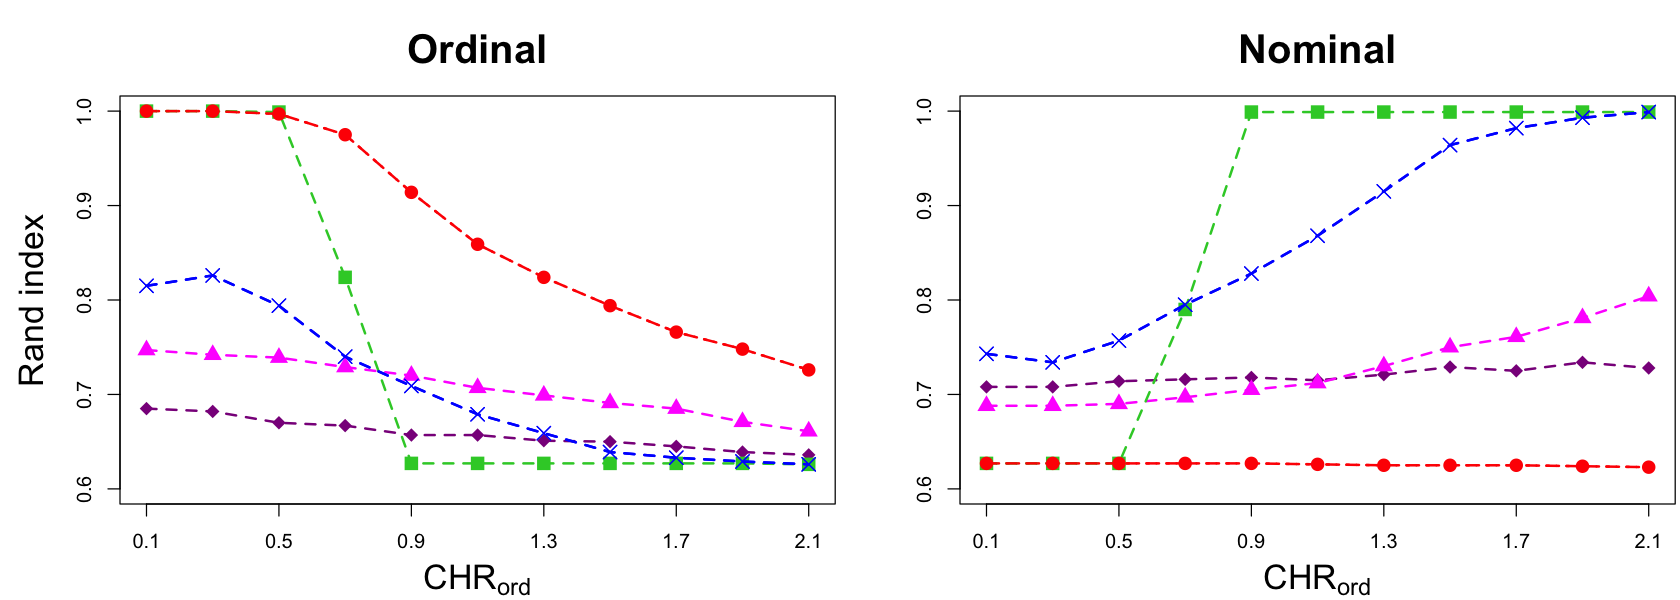

In [73]:
CHR=c(0:10)/5+0.1

options(repr.plot.width = 14, repr.plot.height = 5)
par(mfrow=c(1,2))
par(mar=c(4,5,4,0.2))



pch_lst=c(16,4.2,15,17,18)
col_lst=c("red","blue","Lime Green","magenta","Dark Magenta")

###############################
# rand index

plot(CHR,rand_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="Rand index",main="Ordinal",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))
#TeX("$\\hat{m}_j$")
for(i in c(5:1,2)){
    lines(CHR,rand_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5,cex.lab=1.5)
}

###############################
# rand no index

plot(CHR,rand_no_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="Nominal",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(5:1,2)){
    lines(CHR,rand_no_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_no_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

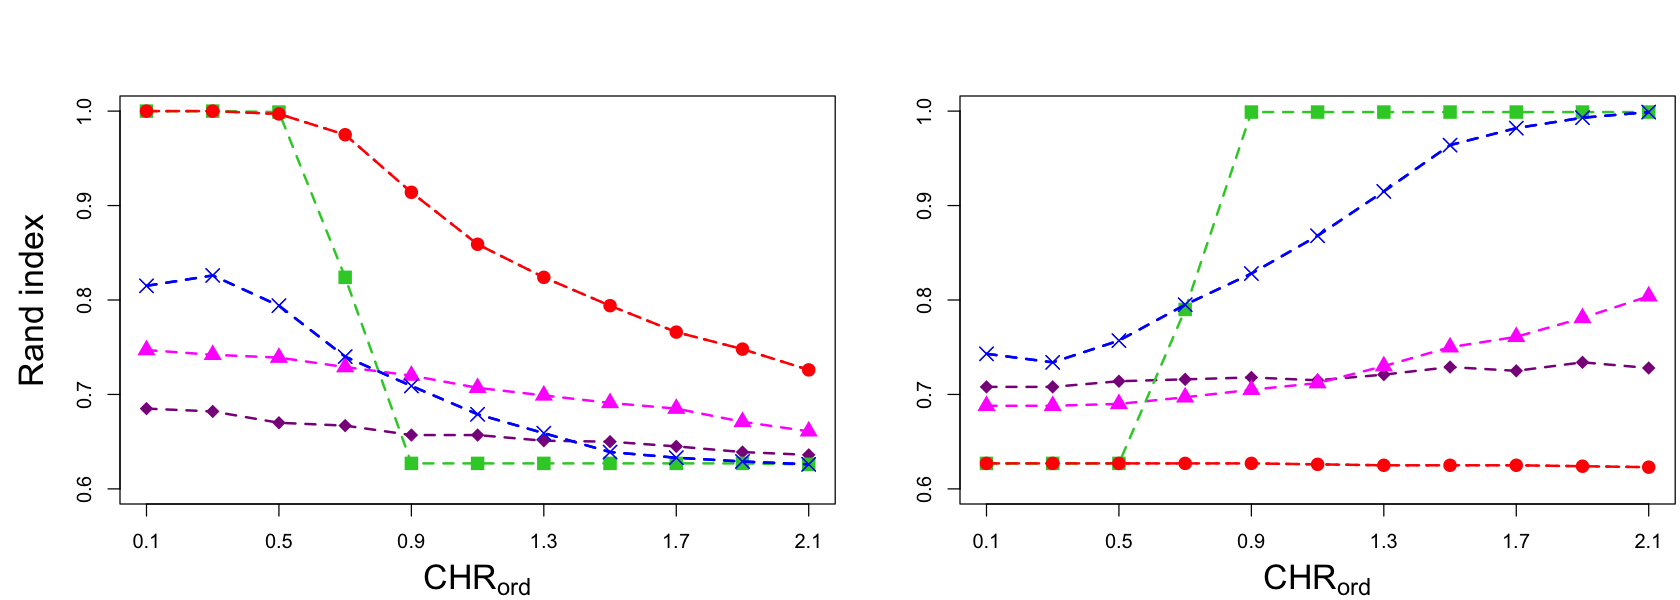

In [74]:
CHR=c(0:10)/5+0.1

options(repr.plot.width = 14, repr.plot.height = 5)
par(mfrow=c(1,2))
par(mar=c(4,5,4,0.2))



pch_lst=c(16,4.2,15,17,18)
col_lst=c("red","blue","Lime Green","magenta","Dark Magenta")

###############################
# rand index

plot(CHR,rand_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="Rand index",main="",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))
#TeX("$\\hat{m}_j$")
for(i in c(5:1,2)){
    lines(CHR,rand_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5,cex.lab=1.5)
}

###############################
# rand no index

plot(CHR,rand_no_mat[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0.6,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="",cex.main=2,cex.lab=1.7)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(5:1,2)){
    lines(CHR,rand_no_mat[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,rand_no_mat[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

## Variable selection

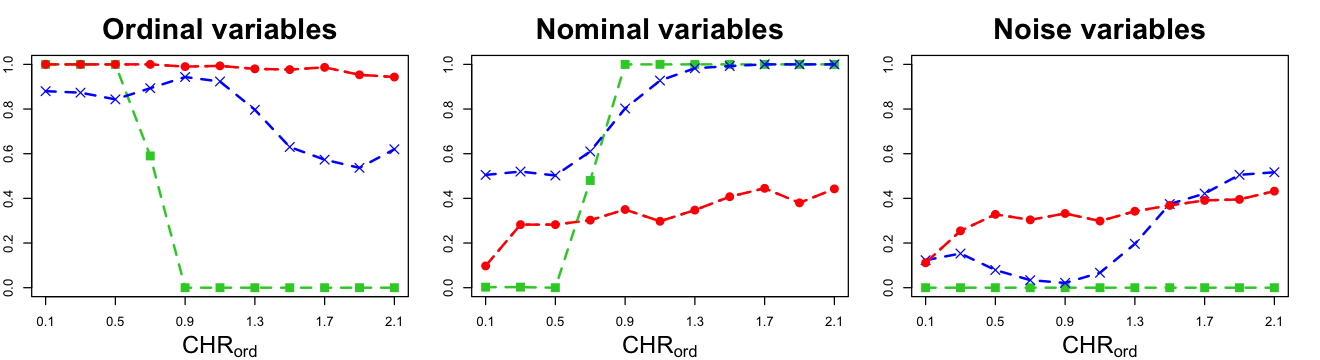

In [75]:
options(repr.plot.width = 11, repr.plot.height = 3)
par(mfrow=c(1,3))
par(mar=c(4,2,3.5,2))


###############################
# Tp of ordinal variables

plot(CHR,tp_ord[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="Ordinal variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_ord[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_ord[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

###############################
# Tp of nominal variables

plot(CHR,tp_nom[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="Nominal variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_nom[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_nom[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}
###############################
# Tp of noise variables

plot(CHR,tp_noi[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="Noise variables",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_noi[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_noi[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

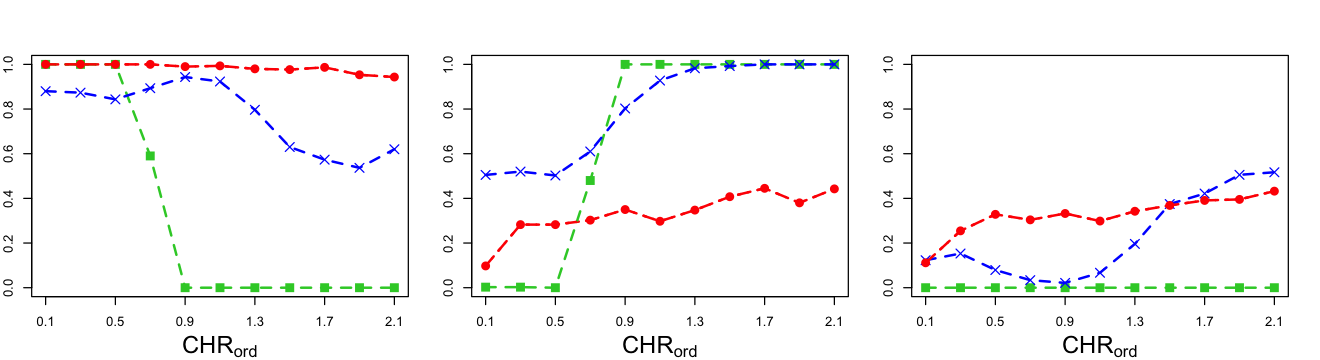

In [76]:
options(repr.plot.width = 11, repr.plot.height = 3)
par(mfrow=c(1,3))
par(mar=c(4,2,3.5,2))


###############################
# Tp of ordinal variables

plot(CHR,tp_ord[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_ord[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_ord[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

###############################
# Tp of nominal variables

plot(CHR,tp_nom[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_nom[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_nom[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}
###############################
# Tp of noise variables

plot(CHR,tp_noi[,1],type="l",xlim=c(min(CHR),max(CHR)),ylim=c(0,1),col=col_lst[1],lwd=2,lty=3,xaxt='n',
    xlab=TeX("$CHR_{ord}$"),ylab="",main="",cex.main=2.2,cex.lab=1.8)
axis(1,at=c(0.1,0.5,0.9,1.3,1.7,2.1))

for(i in c(3:1)){
    lines(CHR,tp_noi[,i],type="l",ylim=c(0,1),col=col_lst[i],lwd=2,lty=2)
    points(CHR,tp_noi[,i],pch=pch_lst[i],col=col_lst[i],cex=1.5)
}

# Kendall

In [77]:
kendall_summary<-function(models){
    for(i in 1:length(models)){
        if(i==1){
            kendall_lst=models[[i]]$kendall
        }else{
            kendall_lst=c(kendall_lst,models[[i]]$kendall) # kendall_correlation values of 100iterations
                                                           # between MOCL clusters and real clusters
        }
    }
    kendall_lst=abs(kendall_lst)
    return(kendall_lst)
}

for(i in 1:length(mm_lst)){
    kendalls_mean=mean(kendall_summary(mm_lst[[i]]))
    kendalls_1se=sd(kendall_summary(mm_lst[[i]]))/sqrt(100)
    if(i==1){
        kendall_mean_lst=kendalls_mean
        kendall_1se_lst=kendalls_1se
    }else{
        kendall_mean_lst=c(kendall_mean_lst,kendalls_mean)
        kendall_1se_lst=c(kendall_1se_lst,kendalls_1se)
    }
}

kendall_lst=list()
kendall_lst[["mean"]]=kendall_mean_lst
kendall_lst[["se"]]=kendall_1se_lst

###############################
# Save
saveRDS(kendall_lst,file="Simulation_CHI_ord_kendall.RData")